In [1]:
pip install torch torchaudio matplotlib pydub openai-whisper


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.2/803.2 kB 9.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for openai-whisper: filename=openai_whisper-20250625-py3-none-any.whl size=803979 sha256=c31ea416249c9d44b01f431af82bed376627c52c7d33025e4d6faaf752b16c4b
  Stored in directory: /root/.cache/pip/wheels/61/d2/20/09ec9bef734d126cba375b15898010b6cc28578d8afdde5869
Successfully built openai-whisper


/usr/local/lib/python3.12/dist-packages/pydub/utils.py:300: SyntaxWarning: invalid escape sequence '\('
  m = re.match('([su]([0-9]{1,2})p?) \(([0-9]{1,2}) bit\)$', token)
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:301: SyntaxWarning: invalid escape sequence '\('
  m2 = re.match('([su]([0-9]{1,2})p?)( \(default\))?$', token)
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:310: SyntaxWarning: invalid escape sequence '\('
  elif re.match('(flt)p?( \(default\))?$', token):
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:314: SyntaxWarning: invalid escape sequence '\('
  elif re.match('(dbl)p?( \(default\))?$', token):


Saving audio_data.m4a to audio_data.m4a
Uploaded: audio_data.m4a
Converted to: converted.wav
Downloading: "https://github.com/snakers4/silero-vad/zipball/master" to /root/.cache/torch/hub/master.zip


/usr/local/lib/python3.12/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on T

Detected 4 speech segments.
[{'start': 37408, 'end': 65504}, {'start': 109600, 'end': 119776}, {'start': 131104, 'end': 144352}, {'start': 153632, 'end': 165344}]


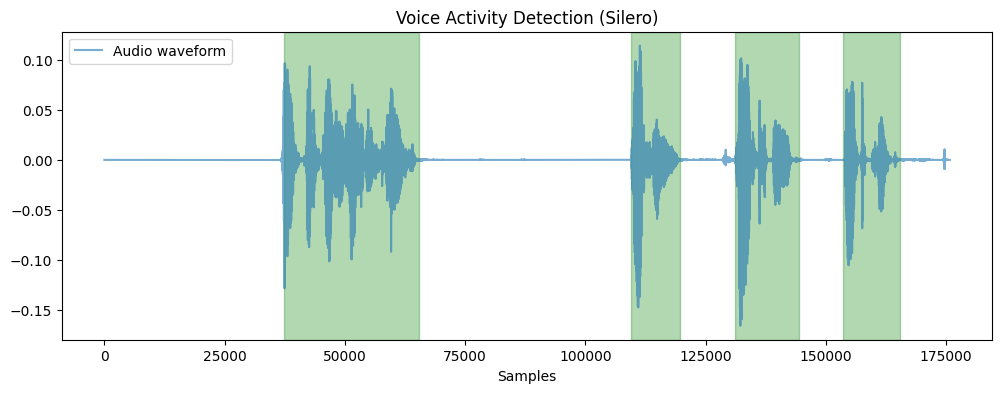

Extracted speech saved as: speech_only.wav


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:337: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.save_with_torchcodec` under the hood. Some parameters like format, encoding, bits_per_sample, buffer_size, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's encoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.encoders.AudioEncoder
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:247: UserWarning: torio.io._streaming_media_encoder.StreamingMediaEncoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  s 

In [2]:
import torch
import torchaudio
import matplotlib.pyplot as plt
from pydub import AudioSegment
from IPython.display import Audio, display
import whisper

from google.colab import files
uploaded = files.upload()

file_name = list(uploaded.keys())[0]
print(f"Uploaded: {file_name}")


audio = AudioSegment.from_file(file_name, format="m4a")
wav_path = "converted.wav"
audio.export(wav_path, format="wav")
print(f"Converted to: {wav_path}")

model, utils = torch.hub.load('snakers4/silero-vad', 'silero_vad', force_reload=True)
(get_speech_timestamps, save_audio, read_audio, VADIterator, collect_chunks) = utils

wav, sr = torchaudio.load(wav_path)
if wav.shape[0] > 1:
    wav = torch.mean(wav, dim=0, keepdim=True)

wav = torchaudio.functional.resample(wav, orig_freq=sr, new_freq=16000).squeeze()
sr = 16000

speech_timestamps = get_speech_timestamps(wav, model, sampling_rate=sr)
print(f"Detected {len(speech_timestamps)} speech segments.")
print(speech_timestamps[:5])

plt.figure(figsize=(12, 4))
plt.plot(wav.numpy(), alpha=0.6, label="Audio waveform")

for ts in speech_timestamps:
    plt.axvspan(ts['start'], ts['end'], color='green', alpha=0.3)

plt.title("Voice Activity Detection (Silero)")
plt.xlabel("Samples")
plt.legend()
plt.show()

speech = collect_chunks(speech_timestamps, wav)
torchaudio.save("speech_only.wav", speech.unsqueeze(0), sr)

print("Extracted speech saved as: speech_only.wav")
display(Audio("speech_only.wav"))


In [3]:
whisper_model = whisper.load_model("tiny")

transcripts = []
for i, ts in enumerate(speech_timestamps):
    start, end = ts['start'], ts['end']
    segment = wav[start:end]
    temp_path = f"segment_{i}.wav"
    torchaudio.save(temp_path, segment.unsqueeze(0), sr)

    result = whisper_model.transcribe(temp_path, language="en")
    transcripts.append(result["text"])
    print(f"[Segment {i+1}] {result['text']}")

full_text = " ".join(transcripts)
print("\n--- FULL TRANSCRIPTION ---\n")
print(full_text)

100%|█████████████████████████████████████| 72.1M/72.1M [00:00<00:00, 77.5MiB/s]
/usr/local/lib/python3.12/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


[Segment 1]  like the same one to three.


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:337: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.save_with_torchcodec` under the hood. Some parameters like format, encoding, bits_per_sample, buffer_size, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's encoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.encoders.AudioEncoder
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:247: UserWarning: torio.io._streaming_media_encoder.StreamingMediaEncoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  s 

[Segment 2]  Marguer.


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:337: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.save_with_torchcodec` under the hood. Some parameters like format, encoding, bits_per_sample, buffer_size, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's encoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.encoders.AudioEncoder
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:247: UserWarning: torio.io._streaming_media_encoder.StreamingMediaEncoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  s 

[Segment 3]  Marguer to


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:337: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.save_with_torchcodec` under the hood. Some parameters like format, encoding, bits_per_sample, buffer_size, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's encoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.encoders.AudioEncoder
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:247: UserWarning: torio.io._streaming_media_encoder.StreamingMediaEncoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  s 

[Segment 4]  Mark III.

--- FULL TRANSCRIPTION ---

 like the same one to three.  Marguer.  Marguer to  Mark III.


In [4]:
!pip install transformers --quiet
from transformers import MarianMTModel, MarianTokenizer

target_lang = "hi"
model_name = f"Helsinki-NLP/opus-mt-en-{target_lang}"


tokenizer = MarianTokenizer.from_pretrained(model_name)
translation_model = MarianMTModel.from_pretrained(model_name)

print("Translating...")
batch = tokenizer([full_text], return_tensors="pt", padding=True)
translated_tokens = translation_model.generate(**batch, max_length=512)
translated_text = tokenizer.decode(translated_tokens[0], skip_special_tokens=True)

print(f"\n--- Translated ({target_lang}) ---\n")
print(translated_text)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/812k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/1.07M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/306M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

Translating...


model.safetensors:   0%|          | 0.00/306M [00:00<?, ?B/s]


--- Translated (hi) ---

वही तीन में से तीन को. मारमूर. मार्क III के लिए मार्कर.
